# Modelo CNN 2D para Compra e Venda de Ações da Companhia Siderúrgica Nacional

Neste modelo usaremos imagens extraídas de um gráfico de colunas que representa o preço de ações da Companhia Siderúrgica Nacional. Cada imagem tem o preço de 15 dias antecessores e foi classificada com os rótulos compra e venda. Essa abordagem permirá o modelo focar em padrões mais curtos, focando no comportamente da curva de preços nos dias anteriores para basear seu processo de decisão.

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,AveragePooling2D
from keras.utils import img_to_array , load_img
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install -U gdown



A pasta imagens fornecida pelo professor foi enviado ao Google Drive pessoal. Como são muitos arquivos essa foi a forma mais simples encontradas a fim de evitar problemas no carregamento das imagens.

# Entrada e Tratamento dos Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#cópia da pasta imagens para a raiz do colab
!cp -r "/content/drive/MyDrive/imagens" "/content/"


In [ ]:
from google.colab import drive
drive.flush_and_unmount()


In [ ]:
!rm -rf /content/drive


In [ ]:
#!gdown --folder https://drive.google.com/drive/folders/1doLAfWyS8JPH3EIU5Mp6wPTdICBQc_5X --remaining-ok -O /content/imagens/treino/vender
#!gdown --folder https://drive.google.com/drive/folders/1dpWT1k13xsyZJOZAFMk71JzitKmQiLpI --remaining-ok -O /content/imagens/treino/comprar

#!gdown --folder https://drive.google.com/drive/folders/1dnZRSbECQLJdtzvvtlvLn7-U34V0DPUW --remaining-ok -O /content/imagens/teste/comprar
#!gdown --folder https://drive.google.com/drive/folders/1dl3bWOJuIk0MdX9C0G4Ye6dPFVOTGVF0 --remaining-ok -O /content/imagens/teste/vender



In [ ]:
import os
import pandas as pd

def carregar_imagens_e_rotulos(diretorio):
    """
    Para criar os conjuntos de treio e teste teremos
    que juntar as imagens que estão em pastas diferentes
    em um único dataframe.
    Os nomes das imagens possuem a data e também o rótulo,
    ambas informações serão extraídas e utilizadas para
    manter a ordem temporal da série, que será ordenada de
    acordo com a coluna Date e também para criar uma coluna
    label.

    """
    data = []

    # Subpastas de compra e venda
    subpastas = ['comprar', 'vender']

    for subpasta in subpastas:
        pasta_completa = os.path.join(diretorio, subpasta)

        for nome_arquivo in os.listdir(pasta_completa):
            if nome_arquivo.endswith('.png'):
                caminho_img = os.path.join(pasta_completa, nome_arquivo) #criação do caminho completo do arquivo

                # Extrair data (antes do underscore)
                data_str = nome_arquivo.split('_')[0]

                # Extrair rótulo do final (_1.png ou _-1.png)
                if nome_arquivo.endswith('_1.png'):
                    label = 1
                elif nome_arquivo.endswith('_-1.png'):
                    label = 0
                else:
                    continue  # ignora arquivos com padrão inesperado

                data.append((caminho_img, data_str, label))

    # Criar DataFrame
    df = pd.DataFrame(data, columns=['image_path', 'date', 'label'])

    # Ordenar pela data (convertendo para datetime para segurança)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date').reset_index(drop=True)

    return df

In [ ]:
df_train = carregar_imagens_e_rotulos('/content/imagens/treino')
df_train.tail(30)

,image_path,date,label
4713,/content/imagens/treino/vender/2019-02-07_-1.png,2019-02-07,0
4714,/content/imagens/treino/vender/2019-02-08_-1.png,2019-02-08,0
4715,/content/imagens/treino/vender/2019-02-11_-1.png,2019-02-11,0
4716,/content/imagens/treino/vender/2019-02-12_-1.png,2019-02-12,0
4717,/content/imagens/treino/vender/2019-02-13_-1.png,2019-02-13,0
4718,/content/imagens/treino/comprar/2019-02-14_1.png,2019-02-14,1
4719,/content/imagens/treino/comprar/2019-02-15_1.png,2019-02-15,1
4720,/content/imagens/treino/comprar/2019-02-18_1.png,2019-02-18,1
4721,/content/imagens/treino/comprar/2019-02-19_1.png,2019-02-19,1
4722,/content/imagens/treino/comprar/2019-02-20_1.png,2019-02-20,1


In [ ]:
print(df_train.iloc[0:50])

                                          image_path       date  label
0   /content/imagens/treino/vender/2000-01-24_-1.png 2000-01-24      0
1   /content/imagens/treino/vender/2000-01-26_-1.png 2000-01-26      0
2   /content/imagens/treino/vender/2000-01-27_-1.png 2000-01-27      0
3   /content/imagens/treino/vender/2000-01-28_-1.png 2000-01-28      0
4   /content/imagens/treino/vender/2000-01-31_-1.png 2000-01-31      0
5   /content/imagens/treino/vender/2000-02-01_-1.png 2000-02-01      0
6   /content/imagens/treino/vender/2000-02-02_-1.png 2000-02-02      0
7   /content/imagens/treino/vender/2000-02-03_-1.png 2000-02-03      0
8   /content/imagens/treino/vender/2000-02-04_-1.png 2000-02-04      0
9   /content/imagens/treino/vender/2000-02-07_-1.png 2000-02-07      0
10  /content/imagens/treino/vender/2000-02-08_-1.png 2000-02-08      0
11  /content/imagens/treino/vender/2000-02-09_-1.png 2000-02-09      0
12  /content/imagens/treino/vender/2000-02-10_-1.png 2000-02-10      0
13  /c

As primeiras 42 entradas do grupo treino tem rótulo de venda, essa informação é importante pois se o nosso batch for muito pequeno é possível que o modelo fique enviesada já no início do treino.  

In [ ]:
df_test = carregar_imagens_e_rotulos('/content/imagens/teste')
print(df_test.head(20))

                                         image_path       date  label
0   /content/imagens/teste/comprar/2019-03-25_1.png 2019-03-25      1
1   /content/imagens/teste/comprar/2019-03-26_1.png 2019-03-26      1
2   /content/imagens/teste/comprar/2019-03-27_1.png 2019-03-27      1
3   /content/imagens/teste/comprar/2019-03-28_1.png 2019-03-28      1
4   /content/imagens/teste/comprar/2019-03-29_1.png 2019-03-29      1
5   /content/imagens/teste/comprar/2019-04-01_1.png 2019-04-01      1
6   /content/imagens/teste/comprar/2019-04-02_1.png 2019-04-02      1
7   /content/imagens/teste/comprar/2019-04-03_1.png 2019-04-03      1
8   /content/imagens/teste/comprar/2019-04-04_1.png 2019-04-04      1
9   /content/imagens/teste/comprar/2019-04-05_1.png 2019-04-05      1
10  /content/imagens/teste/comprar/2019-04-08_1.png 2019-04-08      1
11  /content/imagens/teste/comprar/2019-04-09_1.png 2019-04-09      1
12  /content/imagens/teste/comprar/2019-04-10_1.png 2019-04-10      1
13  /content/imagens

In [ ]:
from PIL import Image


IMG_SIZE = (32, 32)

def carregar_imagens_para_array_pil(df):
    imagens = []
    rotulos = []

    for idx, row in df.iterrows():
        caminho = row['image_path']
        label = row['label']

        try:
            img = Image.open(caminho).convert('L')  # L = greyscale
            img = img.resize(IMG_SIZE)
            img_array = np.array(img).astype(np.float32) / 255.0  # Normaliza

            imagens.append(img_array)
            rotulos.append(label)
        except Exception as e:
            print(f"Erro ao carregar {caminho}: {e}")
            continue

    X = np.array(imagens)
    y = np.array(rotulos)

    return X, y


In [ ]:
X_train, y_train = carregar_imagens_para_array_pil(df_train)

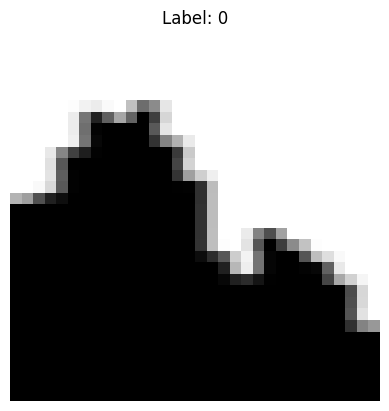

In [ ]:
import matplotlib.pyplot as plt

# Mostrar a primeira imagem
plt.imshow(X_train[0].squeeze(), cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.axis('off')
plt.show()


In [ ]:
X_test, y_test = carregar_imagens_para_array_pil(df_test)

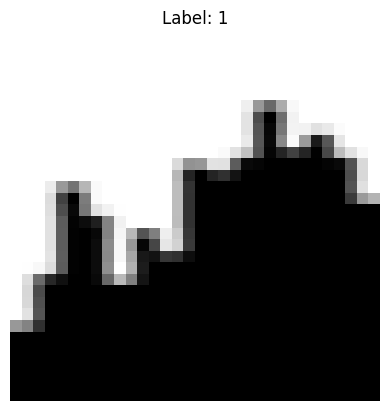

In [ ]:
plt.imshow(X_test[0].squeeze(), cmap='gray')
plt.title(f'Label: {y_test[0]}')
plt.axis('off')
plt.show()

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4743, 32, 32)
(1186, 32, 32)
(4743,)
(1186,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
print(X_train.shape)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(X_test.shape)

(4743, 32, 32, 1)
(1186, 32, 32, 1)


In [ ]:
y_train = np.reshape(y_train, (y_train.shape[0], 1))
print(y_train.shape)

y_test = np.reshape(y_test, (y_test.shape[0], 1))
print(y_test.shape)

(4743, 1)
(1186, 1)


# Modelo

In [ ]:
# Vamos extrair as dimensões das imagens para passar como argumento de entrada na
# primeira camada
d1 = X_train.shape[1]
d2 = X_train.shape[2]
num_classes = 1


In [ ]:
# Cria o modelo
model = Sequential()

#Convolução 2D com função de ativação Rectified Linear Units 64 kernels/Pesos (filtros)
model.add(Conv2D(64, (5, 5), input_shape=(d1,d2,1), activation='relu', padding='same'))
print( model.output_shape)
#Camada de Pooling
model.add(AveragePooling2D(pool_size=(2, 2)))
print( model.output_shape)

#Convolução 2D com função de ativação Rectified Linear Units 128 kernels/Pesos (filtros)
model.add(Conv2D(128, (3, 3), activation='relu'))
print( model.output_shape)
#Camada de Pooling
model.add(AveragePooling2D(pool_size=(2, 2)))
print( model.output_shape)

#Remove 30% dos dados de entrada aleatoriamente
model.add(Dropout(0.3))
#Converte o conjunto de imagens e um vetor unidimensional para a entrada da rede neural totalmente conectada
model.add(Flatten())
print( model.output_shape)

#model.add(Dense(64, activation='relu'))
#print( model.output_shape)
model.add(Dense(64, activation='relu'))
print( model.output_shape)
model.add(Dense(1, activation='sigmoid'))
print( model.output_shape)


(None, 32, 32, 64)
(None, 16, 16, 64)
(None, 14, 14, 128)
(None, 7, 7, 128)
(None, 6272)
(None, 64)
(None, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('model_best.keras', monitor='val_accuracy', mode= 'auto', save_best_only=True, verbose =1)
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp_save])

model.summary()

Epoch 1/30
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8222 - loss: 0.3926
Epoch 1: val_accuracy improved from -inf to 0.88027, saving model to model_best.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 217ms/step - accuracy: 0.8233 - loss: 0.3906 - val_accuracy: 0.8803 - val_loss: 0.2591
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8896 - loss: 0.2543
Epoch 2: val_accuracy improved from 0.88027 to 0.88617, saving model to model_best.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.8896 - loss: 0.2543 - val_accuracy: 0.8862 - val_loss: 0.2545
Epoch 3/30
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8980 - loss: 0.2459
Epoch 3: val_accuracy improved from 0.88617 to 0.89123, saving model to model_best.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.8979 - loss: 0.2460 - val_accuracy: 0.8912 - val_loss: 0.2488
Epoch 4/30
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8976 - loss: 0.2421
Epoch 4: val_accuracy improved from 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 7, 7, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,431,173 (5.46 MB)

 Trainable params: 477,057 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 954,116 (3.64 MB)

Em relação ao modelo LSTM usado para ajustar os dados da VALE S.A. esse modelo apresentou uma performance muito superior. O que pode ser explicado pelo comportamente dos dados. No caso da classificação por imagens o modelo está focando em intervalos de tempo bem mais curtos, o que facilita na identificação de padrões mais curtos, que são geralmente os padrões que são usados no processo de tomada de decisão para um caso como esse.

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('model_best.keras')


In [ ]:
predictions_test = best_model.predict(X_test)
predictions_train = best_model.predict(X_train)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


In [ ]:
pred_test = np.where(predictions_test > 0.5, 1, 0)
pred_train = np.where(predictions_train > 0.5, 1, 0)

In [ ]:
acc = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Acurácia do melhor modelo: {acc[1]:.4f}")

Acurácia do melhor modelo: 0.9030


# Avaliação do modelo

Inicialmente vamos olhar as principais métricas do modelo, representadas pela matriz de confusão e acurácia.

Confusion matrix:
 [[610  78]
 [ 37 461]]
Precision: 0.8553  |  Recall: 0.9257

Classification report:
               precision    recall  f1-score   support

           0     0.9428    0.8866    0.9139       688
           1     0.8553    0.9257    0.8891       498

    accuracy                         0.9030      1186
   macro avg     0.8991    0.9062    0.9015      1186
weighted avg     0.9061    0.9030    0.9035      1186



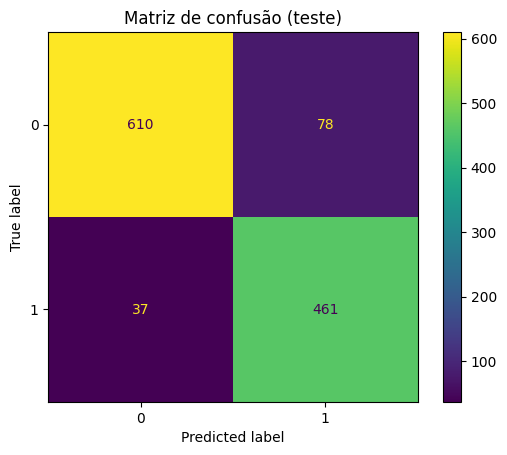

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

#Métricas
cm = confusion_matrix(y_test, pred_test)
prec = precision_score(y_test, pred_test, zero_division=0)
rec  = recall_score(y_test, pred_test, zero_division=0)

print("Confusion matrix:\n", cm)
print(f"Precision: {prec:.4f}  |  Recall: {rec:.4f}")
print("\nClassification report:\n", classification_report(y_test, pred_test, digits=4))

# 4) (opcional) Plot da matriz de confusão
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(values_format="d")
plt.title("Matriz de confusão (teste)")
plt.show()

O modelo tem uma acurácia bastante alta (0.9) representando que essa estratégia de usar figuras das janelas de tempo para cada amostra é muito eficaz para esse problema.

A matriz de confusão nos ajuda a enteder o impacto de acertos e erros em processos de tomada de decisão financeira. Um falso positivo significa que o investidor está entrando no mercado em um momento errado, o que pode levar a prejuízos. Já um falso negativo leva o investidor a vender quando o momento seria de comprar, o que leva a uma diminuição de lucros. Nesse caso o mais importante é obter o máximo possível de acertos, porém um número maior de falsos positivos é mais danoso, pois leva o investidor a entrar no mercado em um momento ruim, o que pode ser mais danoso do que perder oportunidades de compra, de forma que a métrica precision tem um impacto maior para esse problema, pois ela representa quantas vezes o modelo acertou ao atribuir um rótulo de compra.



# Comparação da rotulagem atribuída pelo modelo e por especialistas

Para fazer essa comparação vamos precisar dos valores e não apenas das imagens.

In [ ]:
TRAIN_ID = "1dJGvMrtxbUUjXnQY6CM9ZP9_SujlFLLC"
TEST_ID  = "1dFsOKhdQZ72oH2i6CiGcQ8pbWdMOchtm"

URL_TRAIN = f"https://drive.google.com/uc?export=download&id={TRAIN_ID}"
URL_TEST  = f"https://drive.google.com/uc?export=download&id={TEST_ID}"

df_treino = pd.read_csv(URL_TRAIN)
df_teste = pd.read_csv(URL_TEST)

print("Treino:", df_treino.shape, "Teste:", df_teste.shape)

Treino: (4743, 20) Teste: (1186, 20)


In [ ]:
df_total = pd.concat([df_treino, df_teste])
df_total["Date"] = pd.to_datetime(df_total["Date"])
df_total.head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.409986,1.588954,-1,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777,1.658908
1,2,2000-01-26,1.398052,1.569864,-1,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777
2,3,2000-01-27,1.375888,1.550466,-1,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139
3,4,2000-01-28,1.363953,1.531815,-1,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271
4,5,2000-01-31,1.329854,1.511619,-1,1.363953,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336


O próximo passo será juntas as predições do modelo com a rotulagem efetuada por especialistas em um único dataframe, o que vai nos permitir saber se o modelo obtido é capaz de obter um bom resultado financeiro.

In [ ]:
# Combine predictions with the dates from the image dataframes
pred_df_train = pd.DataFrame({'date': df_train['date'], 'Pred_img': pred_train.flatten()})
pred_df_test = pd.DataFrame({'date': df_test['date'], 'Pred_img': pred_test.flatten()})

# Concatenate the prediction dataframes
pred_combined = pd.concat([pred_df_train, pred_df_test])

# Convert 'Date' column in df_total to datetime for merging
df_total["Date"] = pd.to_datetime(df_total["Date"])
pred_combined['date'] = pd.to_datetime(pred_combined['date'])

# Merge df_total with the predictions based on date, handling suffixes
df_total = pd.merge(df_total, pred_combined, left_on='Date', right_on='date', how='left', suffixes=('', '_pred_img'))

# Drop the extra date column from the merge
df_total = df_total.drop('date', axis=1)

# Rename the merged prediction column to 'Pred_img' and drop the original if it exists
if 'Pred_img_pred_img' in df_total.columns:
    df_total['Pred_img'] = df_total['Pred_img_pred_img']
    df_total = df_total.drop(columns=['Pred_img_pred_img'], errors='ignore')

df_total["Label"] = df_total["Label"].replace(-1, 0)

df_final = df_total[['Date','Close', 'Label', 'Pred_img']]
# Converte apenas valores válidos; se não puder, vira NaN
df_final['Pred_img'] = pd.to_numeric(df_final['Pred_img'], errors='coerce').astype('Int64')
df_final.dropna(inplace=True)

display(df_final.head())

/tmp/ipython-input-3271268894.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Pred_img'] = pd.to_numeric(df_final['Pred_img'], errors='coerce').astype('Int64')
/tmp/ipython-input-3271268894.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.dropna(inplace=True)


,Date,Close,Label,Pred_img
0,2000-01-24,1.409986,0,0
1,2000-01-26,1.398052,0,0
2,2000-01-27,1.375888,0,0
3,2000-01-28,1.363953,0,0
4,2000-01-31,1.329854,0,0


In [ ]:
df_final['Pred_img'].isnull().sum()


np.int64(0)

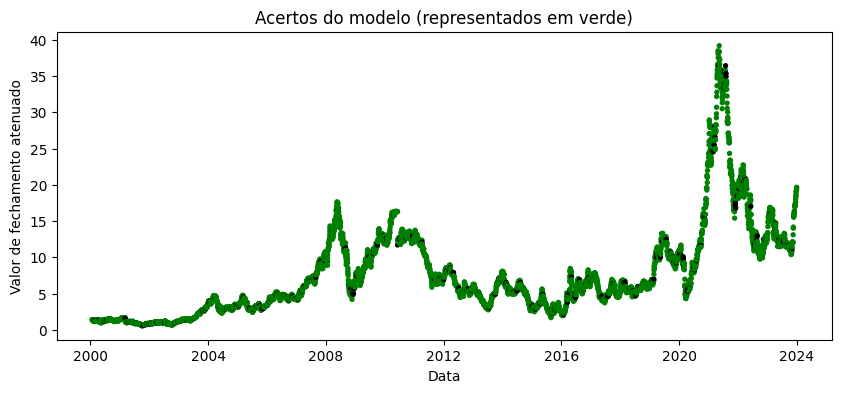

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.scatter(df_final["Date"], df_final["Close"],
            c=np.where(df_final['Label'] == df_final['Pred_img'], "green", "black"), s=8)


plt.ylabel("Valor de fechamento atenuado")
plt.xlabel("Data")
plt.title("Acertos do modelo (representados em verde)")

#plt.grid(True, linestyle="--", alpha=0.1)
plt.show()

No gráfico acima podemos ver que há uma grande predominância de valores em verde, o que representa uma porcentagem bastante significativa de acertos do modelo.

Para comparar os resultados financeiros obtidos criamos uma função que calcula o patrimonio total (caixa + nº de ações*valor das ações) de acordo com as seguintes regras:

*   Começa com um caixa inicial e um número inicial de ações
*   Compra 1 ação se rótulo = 1
*   Vende 1 ação se rótulo = 0



In [ ]:
def retorno_financeiro(df, caixa_inicial, acoes_inicial):
  Ci = caixa_inicial
  Qi = acoes_inicial
  rotulos = df["Label"]
  precos = df["Close"]
  patrimonio = []
  patrimoio_inicial = Ci + (Qi * precos.iloc[0])
  for i in range(1, len(rotulos)):
    if rotulos.iloc[i] == 1:
      Ci = Ci - (precos.iloc[i-1])
      Qi = Qi + 1
    elif rotulos.iloc[i] == 0:
      Ci = Ci + (precos.iloc[i-1] )
      Qi = Qi - 1
    patrimonio.append(Ci + (Qi * precos.iloc[i]))

  patrimonio_final = patrimonio[-1]
  print(f"O patrimonio inicial: {patrimonio[0]:.2f}")
  print(f"O patrimônio final obtido foi de: {patrimonio_final:.2f}")
  return patrimonio

In [ ]:
retorno_especialista = retorno_financeiro(df_final, 10000, 1000)

O patrimonio inicial: 11398.06
O patrimônio final obtido foi de: 19443.48


In [ ]:
df_modelo = df_final[['Date', 'Close', 'Pred_img']]
df_modelo.columns = ['Date', 'Close', 'Label']
df_modelo.head()

,Date,Close,Label
0,2000-01-24,1.409986,0
1,2000-01-26,1.398052,0
2,2000-01-27,1.375888,0
3,2000-01-28,1.363953,0
4,2000-01-31,1.329854,0


In [ ]:
retorno_modelo = retorno_financeiro(df_modelo, 10000, 1000)

O patrimonio inicial: 11398.06
O patrimônio final obtido foi de: 21803.30


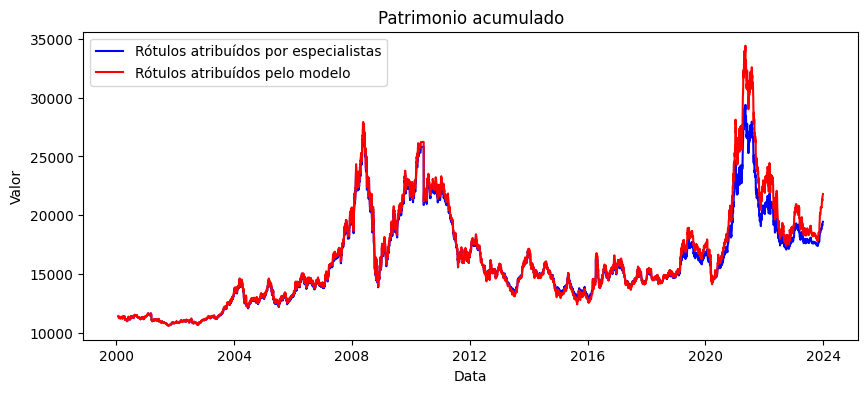

In [ ]:
plt.figure(figsize=(10,4))


plt.plot(df_final["Date"][1:], retorno_especialista, color="blue", label="Rótulos atribuídos por especialistas")
plt.plot(df_modelo["Date"][1:], retorno_modelo, color="red", label="Rótulos atribuídos pelo modelo")


plt.ylabel("Valor")
plt.xlabel("Data")
plt.title("Patrimonio acumulado")
plt.legend()

plt.show()

Os ganhos financeiros calculados pela nossa função teste usando os rótulos fornecidos (em azul) e os obtidos pelo modelo Conv2D (em vermelho) estão muito próximos. Dentre todas as estratégias usadas nos diferentes datasets fornecidos a rede convolucional 2D foi a que performou melhor. Possivelmente porque o uso de imagens que representavam janelas de tempo de 15 passos fez o modelo capturar de forma eficiente padrões locais, enquanto modelos sequenciais como LSTM e TCN são mais indicados para dependências temporais mais longas.